## Dataset Description

This dataset is synthesized by IBM from a multi-agent virtual world simulation, including synthetic consumers that travel globally. It spans decades of transactions and multiple cards per consumer. The synthetic data generated is designed to mimic real-world data as closely as possible in terms of fraud rates, purchase amounts, Merchant Category Codes (MCCs), and other metrics, thereby providing a reliable dataset for training and evaluating fraud detection models.

Though synthesized, this data has been crafted to mimic the real-world scenarios of credit card transactions, including the variances in shopping behaviors, purchase amounts, merchant variety, locations, and even fraudulent transactions, thus being a valuable resource for creating and testing credit card fraud detection models. The generation process involved intricate techniques and detailed consumer domains, resulting in a dataset that closely parallels real-world data.

This rich, synthetic dataset enables researchers and developers to explore, create, and test models in a domain where typically data availability is highly restricted due to privacy considerations. The 'natural' value columns in the dataset can be exploited for feature engineering to improve model performance.

The author's work does not involve using this data to develop and train models to predict fraud, or coupling models and the synthetic dataset to assess performance in designing accelerators such as GPUs and TPUs. Those aspects are left to the users of this dataset, offering a wide scope for exploration and innovation.

### Column Descriptions

1. **User**: The unique identifier of the credit card user.
2. **Card**: The unique identifier of the credit card used for the transaction.
3. **Year**: The year when the transaction took place.
4. **Month**: The month when the transaction took place.
5. **Day**: The day when the transaction took place.
6. **Time**: The specific time when the transaction took place.
7. **Amount**: The total monetary value of the transaction.
8. **Use Chip**: Indicates whether the chip on the credit card was used for the transaction.
9. **Merchant Name**: The unique identifier of the merchant where the transaction took place.
10. **Merchant City**: The city where the merchant is located.
11. **Merchant State**: The state where the merchant is located.
12. **Zip**: The zip code of the area where the transaction took place.
13. **MCC**: The Merchant Category Code, which is a four-digit number used to categorize the type of business or service the company provides.
14. **Errors?**: Any errors that occurred during the transaction.
15. **Is Fraud?**: Indicates whether the transaction was fraudulent.

#### Citation

Altman, E.R., 2019. Synthesizing Credit Card Transactions. arXiv preprint arXiv:1910.03033. DOI: https://doi.org/10.48550/arXiv.1910.03033


## Load and merge data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import openpyxl

# Load the transactions data and drop unnecessary columns
transactions = pd.read_csv('final_dataset.csv')
transactions = transactions.drop(['Merchant State', 'Merchant City'], axis=1)
transactions = transactions.rename(columns={'Year':'Transaction Year','Month':'Transaction Month','Day':'Transaction Day','Time':'Transaction Time'})

# Convert 'Year', 'Month', 'Day' columns to datetime format and drop the original columns
transactions['datetime'] = pd.to_datetime(transactions['Transaction Year'].astype(str) + '-' + transactions['Transaction Month'].astype(str) + '-' + transactions['Transaction Day'].astype(str) + ' ' + transactions['Transaction Time'].astype(str) + ':00')
transactions = transactions.drop(['Transaction Year', 'Transaction Month', 'Transaction Day', 'Transaction Time'], axis=1)

# Load the cards data and drop unnecessary columns
cards = pd.read_csv("sd254_cards.csv")
cards = cards.drop(['CVV', 'Year PIN last Changed'], axis=1)

# Load the users data and drop unnecessary columns 
users = pd.read_csv("sd254_users.csv")
users = users.drop(['Person', 'Address','Birth Month', 'Apartment', 'City', 'State', 'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt'], axis=1)
users = users.rename(columns={'latitude': 'user_latitude', 'longitude': 'user_longitude'})

# Reset index to create a 'User' column
users = users.reset_index().rename(columns={'index': 'User'})

# Load zip code data and rename columns
zip_df = pd.read_excel("zipcode_map.xlsx")
zip_df = zip_df.rename(columns={'latitude': 'merchant_latitude', 'longitude': 'merchant_longitude', 'postal code': 'Zip'})

# Merge the datasets
df = pd.merge(transactions, cards, left_on=['User', 'Card'], right_on=['User', 'CARD INDEX'], how='left')
df = pd.merge(df, users, left_on=['User'], right_on=['User'], how='left')
df = pd.merge(df, zip_df, left_on=['Zip'], right_on=['Zip'], how='left')
df

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76399 entries, 0 to 76398
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   User                76399 non-null  int64         
 1   Card                76399 non-null  int64         
 2   Amount              76399 non-null  object        
 3   Use Chip            76399 non-null  object        
 4   Merchant Name       76399 non-null  int64         
 5   Zip                 76399 non-null  float64       
 6   MCC                 76399 non-null  int64         
 7   Errors?             76399 non-null  object        
 8   Is Fraud?           76399 non-null  object        
 9   datetime            76399 non-null  datetime64[ns]
 10  CARD INDEX          76399 non-null  int64         
 11  Card Brand          76399 non-null  object        
 12  Card Type           76399 non-null  object        
 13  Card Number         76399 non-null  int64     

## Pre Processing


### Drop unwanted columns as convert data types

In [3]:
# Remove unnecessary columns and duplicate columns such as zip code since we already have long and lat we will not need these

df.drop(columns=['Card','CARD INDEX',"Zip",'Zipcode','Card Number'],inplace=True, axis=1)

# Convert money columns to float by removing dollar symbols so they can be used as inputs to model, the money symbol will make it a string

df["Amount"]=df["Amount"].str.replace("$","").astype(float)
df["Credit Limit"]=df["Credit Limit"].str.replace("$","").astype(float)
df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

df.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 76399 entries, 0 to 76398
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   User                76399 non-null  int64         
 1   Amount              76399 non-null  float64       
 2   Use Chip            76399 non-null  object        
 3   Merchant Name       76399 non-null  int64         
 4   MCC                 76399 non-null  int64         
 5   Errors?             76399 non-null  object        
 6   Is Fraud?           76399 non-null  int64         
 7   datetime            76399 non-null  datetime64[ns]
 8   Card Brand          76399 non-null  object        
 9   Card Type           76399 non-null  object        
 10  Expires             76399 non-null  object        
 11  Has Chip            76399 non-null  object        
 12  Cards Issued        76399 non-null  int64         
 13  Credit Limit        76399 non-null  float64   

### Enrich the dataset

In [4]:
# Extract month, day of the week, and hour from the 'datetime' column
df = df.assign(Month=df['datetime'].apply(lambda x: x.month),
               DayOfWeek=df['datetime'].apply(lambda x: x.weekday()),
               Day=df['datetime'].apply(lambda x: x.day),
               Hour=df['datetime'].apply(lambda x: x.hour))

# Calculate the credit limit utilization percentage
df['CreditLimitUtilization'] = df['Amount'] / df['Credit Limit']

# Calculate the time difference in days between 'Acct Open Date' and 'datetime'
df['Acct Open Date'] = pd.to_datetime(df['Acct Open Date'], format='%m/%Y')
df['DaysSinceAcctOpen'] = (df['datetime'] - df['Acct Open Date']).dt.days

df.drop(columns=['Expires','datetime','Acct Open Date','Merchant Name','Retirement Age','datetime','Birth Year'],axis=True,inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 76399 entries, 0 to 76398
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   User                    76399 non-null  int64  
 1   Amount                  76399 non-null  float64
 2   Use Chip                76399 non-null  object 
 3   MCC                     76399 non-null  int64  
 4   Errors?                 76399 non-null  object 
 5   Is Fraud?               76399 non-null  int64  
 6   Card Brand              76399 non-null  object 
 7   Card Type               76399 non-null  object 
 8   Has Chip                76399 non-null  object 
 9   Cards Issued            76399 non-null  int64  
 10  Credit Limit            76399 non-null  float64
 11  Card on Dark Web        76399 non-null  object 
 12  Current Age             76399 non-null  int64  
 13  Gender                  76399 non-null  object 
 14  Latitude                76399 non-null

### Imputation of missing values

In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import math
from sklearn.impute import SimpleImputer
from geopy import distance
import numpy as np

#### The Iterative Imputer, which uses a form of multiple imputation, can also capture complex patterns and is typically less computationally intensive than random forests. It fills each missing value by using a regression model that predicts the missing value using the remaining variables, and it does this in a round-robin fashion.
#### Chose iterative due to computational limitations of my system and since the data was large

imp = IterativeImputer(max_iter=10, random_state=0)

df[['Latitude', 'Longitude', 'merchant_latitude', 'merchant_longitude','accuracy']] = imp.fit_transform(df[['Latitude', 'Longitude', 'merchant_latitude', 'merchant_longitude','accuracy']])


# Create an imputer object with a most_frequent filling strategy
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# List of categorical columns that have missing values
cat_cols_with_missing = ['country code', 'place name', 'admin name1', 'admin name2', 'admin code1', 'admin code2']

# Fit on the dataset and then transform it
df[cat_cols_with_missing] = imputer.fit_transform(df[cat_cols_with_missing])



# Define function to calculate Great Circle Distance
def great_circle_dist(lat1, lon1, lat2, lon2):
    coord1 = (lat1, lon1)
    coord2 = (lat2, lon2)
    return distance.great_circle(coord1, coord2).km

# Apply function to DataFrame
df['DistanceTransactionToMerchant'] = df.apply(lambda row: great_circle_dist(row['Latitude'], row['Longitude'], row['merchant_latitude'], row['merchant_longitude']), axis=1)

# Calculate direction
df['DirectionTransactionToMerchant'] = df.apply(lambda row: math.degrees(math.atan2(row['merchant_longitude'] - row['Longitude'], row['merchant_latitude'] - row['Latitude'])), axis=1)


### Encoding and Scalling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define categorical and numerical features
categorical_features = ['Use Chip', 'Errors?', 'Card Brand', 'Card Type', 'Has Chip', 'Card on Dark Web', 'Gender', 'country code', 'admin name1', 'admin code1', 'admin name2','place name']
numerical_features = ['User','Amount', 'MCC', 'Cards Issued', 'Latitude', 'Longitude', 'admin code2', 'Num Credit Cards', 'merchant_latitude', 'merchant_longitude', 'accuracy', 'Month', 'DayOfWeek', 'Day', 'Hour', 'DaysSinceAcctOpen','Current Age','DistanceTransactionToMerchant', 'DirectionTransactionToMerchant']

# Define preprocessing for numerical and categorical features
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

### Split Training and Testing set

In [ ]:
# Divide the dataset into features and labels
X = df.drop('Is Fraud?', axis=1)
y = df['Is Fraud?']

# Split your data into a training set and a test set (80-20 split here)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: fit_transform on train data
X_train = preprocessor.fit_transform(X_train)

# Preprocessing: transform only on test data
X_test = preprocessor.transform(X_test)

print(X_train)

## Feature Selection

[LightGBM] [Info] Number of positive: 186, number of negative: 60933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 61119, number of used features: 991
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003043 -> initscore=-5.791784
[LightGBM] [Info] Start training from score -5.791784
Feature: DistanceTransactionToMerchant, Score: 259.00000
Feature: DaysSinceAcctOpen, Score: 245.00000
Feature: MCC, Score: 208.00000
Feature: DirectionTransactionToMerchant, Score: 165.00000
Feature: Amount, Score: 161.00000
Feature: merchant_longitude, Score: 142.00000
Feature: Hour, Score: 142.00000
Feature: User, Score: 124.00000
Feature: merchant_latitude, Score: 118.00000
Feature: Current Age, Score: 112.00000
Feature: admin code2,

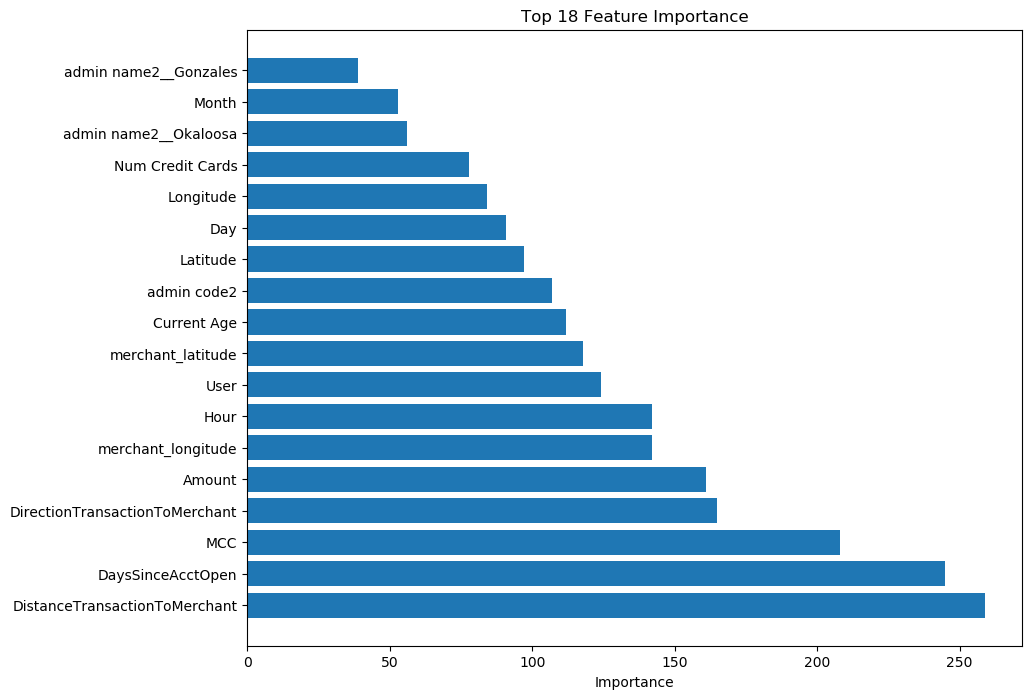

In [9]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd

# train the LightGBM model
model = lgb.LGBMClassifier(objective='binary', random_state=42)
model.fit(X_train, y_train)

# get feature importance
importance = model.feature_importances_

# Get the list of categorical features after one-hot encoding
ohe_categories = preprocessor.named_transformers_['cat'].named_steps['encoder'].categories_
new_ohe_features = [f"{col}__{val}" for col, vals in zip(categorical_features, ohe_categories) for val in vals]

# Combine the numerical and new one-hot encoded features
feature_names = numerical_features + new_ohe_features

# create a DataFrame with feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Score': importance
})

# Save all feature importance scores to a csv file
importance_df.to_csv('feature_importance.csv', index=False)

# sort the DataFrame by 'Score' in descending order and select the top 12
top_18_features = importance_df.sort_values('Score', ascending=False).head(18)

# Print the top 12 feature importance scores
for index, row in top_18_features.iterrows():
    print('Feature: %s, Score: %.5f' % (row['Feature'], row['Score']))

# plot feature importance of the top 12 features
plt.figure(figsize=(10, 8))
plt.barh(top_18_features['Feature'], top_18_features['Score'])
plt.xlabel('Importance')
plt.title('Top 18 Feature Importance')
plt.show()


## Finding best parameters

In [ ]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

role = get_execution_role()

# Get the XGBoost container
region = boto3.Session().region_name
container = retrieve('xgboost', region, version='1.0-1')

bucket = 'sagemaker-us-east-1-952246968985'  # Replace with your S3 bucket name
prefix = 'sagemaker/xgboost-tuning'  # Replace with the prefix under which you want to store the data

# Set up the estimator
xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker.Session())

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='binary:logistic',
                        num_round=100)

# Set up the hyperparameter tuning job
xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, 
                                               objective_metric_name = 'validation:auc', 
                                               objective_type = 'Maximize', 
                                               max_jobs = 20, 
                                               max_parallel_jobs = 3, 
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 12),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

# Define the data locations in S3
s3_input_train = TrainingInput(s3_data='s3://{}/train/train.csv'.format(bucket), content_type='csv')
s3_input_validation = TrainingInput(s3_data='s3://{}/test/test.csv'.format(bucket), content_type='csv')

# Start the hyperparameter tuning job
xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})


### When the warning One or more of the test scores are non-finite appears, it means that the scoring function returned NaN (not a number) for one or more combinations of hyperparameters. This typically happens when a model fails to converge, or perhaps due to an inappropriate combination of hyperparameters. In this context, NaN values are ignored, and the best parameters are chosen among those that provided valid (finite) scores.

### However, you might want to investigate why these scores are non-finite and possibly adjust your hyperparameters to prevent these cases. You might also want to consider normalizing or standardizing your features, handling missing values or outliers, or choosing different hyperparameters or a different solver.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Instantiate the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=0)

# Define the parameters grid
param_dist = {
    'n_estimators': randint(50, 200),
    'max_features': ['sqrt',None],
    'max_depth': randint(10, 30)
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, 
                                   n_iter=10, cv=3, scoring='f1', verbose=2, n_jobs=-1, random_state=0)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_

print(f"Best parameters found:  {best_params}")

# Best parameters found:  {'max_depth': 22, 'max_features': None, 'n_estimators': 167}

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'max_depth': 19, 'max_features': None, 'n_estimators': 71}


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Define our parameters 
parameters = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3], 
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [100, 200, 300, 400, 500],
    'min_child_weight': [1, 2, 3, 4]
}

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Use RandomizedSearchCV and early stopping
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=parameters, cv=3, scoring='recall', n_jobs=-1, n_iter=50)
random_search.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)])

# Print the best parameters and highest recall
print(f"Best parameters found:  {random_search.best_params_}")
print(f"Best recall found:  {random_search.best_score_}")


## Models with best parameters

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer


# Instantiate the model with the best parameters
lr_model = LogisticRegression(C=1, penalty='l1', solver='liblinear', random_state=0)

# Fit the model to the training data
lr_model.fit(X_train, y_train)

# Predict the labels of the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
print('Logistic Regression performance:')
print('Accuracy:', accuracy_score(y_test, y_pred_lr))
print('Precision:', precision_score(y_test, y_pred_lr))
print('Recall:', recall_score(y_test, y_pred_lr))
print('F1 Score:', f1_score(y_test, y_pred_lr))

# convert labels to binary
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_pred_lr_bin = lb.transform(y_pred_lr)

print('ROC AUC Score:', roc_auc_score(y_test_bin, y_pred_lr_bin))


Logistic Regression performance:
Accuracy: 0.9994109947643979
Precision: 0.9615384615384616
Recall: 0.7575757575757576
F1 Score: 0.8474576271186441
ROC AUC Score: 0.8787550854514847


Accuracy: 0.9994 - This indicates that the model correctly predicted whether a transaction was fraudulent or not approximately 99.94% of the time.
Precision: 0.9615 - This shows that when the model predicted a transaction to be fraudulent, it was correct 96.15% of the time.
Recall: 0.7576 - This tells us that of all the actual fraudulent transactions, the model was able to correctly identify 75.76% of them.
F1 Score: 0.8475 - This is the harmonic mean of precision and recall and provides a balanced measure of the model's performance. It is particularly useful when the classes are unevenly distributed.
ROC AUC Score: 0.8788 - This is the Area Under the Receiver Operating Characteristic curve. It tells us how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at distinguishing between fraudulent and non-fraudulent transactions.
The results look pretty good given that the accuracy, precision, and ROC AUC scores are quite high. However, there's some room for improvement in recall, which could mean that the model is missing a relatively higher number of actual fraudulent transactions. This might be okay depending on the specific business context and how the model's predictions are being used. In a fraud detection scenario, it is often more important to catch as many fraudulent transactions as possible (higher recall), even if that means occasionally flagging some legitimate transactions as fraudulent (lower precision).

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Instantiate the model with the best parameters
rf_model = RandomForestClassifier(max_depth=19, max_features=None, n_estimators=71, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = rf_model.predict(X_test)

# Print performance metrics
print("Random Forest performance:")
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

Random Forest performance:
Accuracy: 0.999607329842932
Precision: 0.9090909090909091
Recall: 0.9090909090909091
F1 Score: 0.9090909090909091


In [12]:
# Fit the model with best parameters
best_xgb_model = xgb.XGBClassifier(
    n_estimators=100, 
    min_child_weight=3, 
    max_depth=5, 
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss'
)

best_xgb_model.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = best_xgb_model.predict(X_test)

# Importing the required metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Performance
print("XGBoost performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, best_xgb_model.predict_proba(X_test)[:, 1])}")


XGBoost performance:
Accuracy: 0.99967277486911
Precision: 1.0
Recall: 0.8484848484848485
F1 Score: 0.9180327868852458
ROC AUC Score: 0.9979668131435693
